Notes:
 * revised and tuned configuration, updated views

In [27]:
import os

chkpt_root = '/mnt/tess/astronet/checkpoints/revised_tuned_30_run_1'
data_files = '/mnt/tess/astronet/tfrecords-30-val/*'
tces_file = '/mnt/tess/astronet/tces-v8-val.csv'

nruns = 10

def load_ensemble(chkpt_root, nruns):
    checkpts = []
    for i in range(nruns):
        parent = os.path.join(chkpt_root, str(i + 1))
        if not os.path.exists(parent):
            break
        all_dirs = os.listdir(parent)
        if not all_dirs:
            break
        d, = all_dirs
        checkpts.append(os.path.join(parent, d))
    return checkpts

paths = load_ensemble(chkpt_root, nruns)
paths

['/mnt/tess/astronet/checkpoints/revised_tuned_30_run_1/1/AstroCNNModel_revised_tuned_20211013_015513',
 '/mnt/tess/astronet/checkpoints/revised_tuned_30_run_1/2/AstroCNNModel_revised_tuned_20211013_020014',
 '/mnt/tess/astronet/checkpoints/revised_tuned_30_run_1/3/AstroCNNModel_revised_tuned_20211013_020440',
 '/mnt/tess/astronet/checkpoints/revised_tuned_30_run_1/4/AstroCNNModel_revised_tuned_20211013_020901',
 '/mnt/tess/astronet/checkpoints/revised_tuned_30_run_1/5/AstroCNNModel_revised_tuned_20211013_021315',
 '/mnt/tess/astronet/checkpoints/revised_tuned_30_run_1/6/AstroCNNModel_revised_tuned_20211013_021730',
 '/mnt/tess/astronet/checkpoints/revised_tuned_30_run_1/7/AstroCNNModel_revised_tuned_20211013_022143',
 '/mnt/tess/astronet/checkpoints/revised_tuned_30_run_1/8/AstroCNNModel_revised_tuned_20211013_022606',
 '/mnt/tess/astronet/checkpoints/revised_tuned_30_run_1/9/AstroCNNModel_revised_tuned_20211013_023040',
 '/mnt/tess/astronet/checkpoints/revised_tuned_30_run_1/10/Astro

In [28]:
import getpass
import os
from astronet import predict
import tensorflow as tf


def run_predictions(path):
    predict.FLAGS = predict.parser.parse_args([
      '--model_dir', path,
      '--data_files', data_files,
      '--output_file', '',
    ])

    return predict.predict()


paths = load_ensemble(chkpt_root, nruns)
ensemble_preds = []
config = None
for i, path in enumerate(paths):
    print(f'Running model {i + 1}')
    preds, config = run_predictions(path)
    ensemble_preds.append(preds.set_index('tic_id'))
    print()

Running model 1
2233 records
Running model 2
2233 records
Running model 3
2233 records
Running model 4
2233 records
Running model 5
2233 records
Running model 6
2233 records
Running model 7
2233 records
Running model 8
2233 records
Running model 9
2233 records
Running model 10
2233 records


In [41]:
labels = ['disp_e', 'disp_n', 'disp_j', 'disp_s', 'disp_b']

col_e = labels.index('disp_e')
thresh = 0.030499761581475493

In [42]:
import numpy as np
import pandas as pd

agg_preds = {}

for preds in ensemble_preds:
    for tic_id in preds.index:
        if tic_id not in agg_preds:
            agg_preds[tic_id] = []

        row = preds[preds.index == tic_id]
        pred_v = row.values[0]
        if len(row.values) > 1:
            print(f'Warning: duplicate predictions for {tic_id}')
        if pred_v[col_e] >= thresh:
            agg_preds[tic_id].append('disp_e')
        else:
            masked_v = [v if i != col_e else 0 for i, v in enumerate(pred_v)]
            agg_preds[tic_id].append(preds.columns[np.argmax(masked_v)])

In [43]:
final_preds = []
for tic_id in list(agg_preds.keys()):
    counts = {l: 0 for l in labels}
    for e in agg_preds[tic_id]:
        counts[e] += 1
    maxcount = max(counts.values())
    counts.update({
        'tic_id': tic_id,
        'maxcount': maxcount,
    })
    final_preds.append(counts)
    
final_preds = pd.DataFrame(final_preds).set_index('tic_id')

In [44]:
tce_table = pd.read_csv(tces_file, header=0).set_index('tic_id')
for l in labels:
    tce_table[l] = tce_table[l[:-1] + l[-1].upper()]
tce_labels = tce_table[labels]

pl = final_preds.join(tce_labels, on='tic_id', how='left', lsuffix='_p')

pl.head()
pd.set_option('display.max_columns', None)

In [45]:
ppos = (pl['disp_e_p'] > 0)
pos = (pl['disp_e'] > 0)

pneg = (pl['disp_e_p'] == 0)
neg = (pl['disp_e'] == 0)

print('Recall:', len(pl[ppos & pos]) / len(pl[pos]))
print('Precision:', len(pl[ppos & pos]) / len(pl[ppos]))

Recall: 1.0
Precision: 0.4978540772532189


In [46]:
for i in pl[pos & pneg][[]].join(tce_table, on='tic_id', how='left').index:
    print(i)

In [47]:
for i in pl[neg & ppos][[]].join(tce_table, on='tic_id', how='left').index:
    print(i)

282535014
283330382
28570131
375927073
385776685
69906465
136728967
14209654
163367359
16740282
170653829
188258751
188655930
1954685032
199376584
232524196
267924099
276165770
356776209
416282321
136651206
154214348
202442062
239639659
24860612
277848886
278555119
278910035
312821931
330470939
357302392
395986110
417208086
431416493
469465627
2041994942
252588526
367610104
431338538
117170301
192591652
196919670
198555242
240833511
240897594
249917671
279064110
301829477
309230360
312060273
332870317
347492958
381847922
468608862
470684484
622842565
94280922
127846210
21133246
154699543
156509985
164528404
165500081
165614600
18178958
188728924
233197293
237278147
274483823
27896467
356822358
377253895
390973110
405687343
470085803
261814771
269291226
391032362
408602527
408945155
428942240
470309381
646535555
648359612
82242456
142615793
142751024
147608359
147879328
154491644
257048642
56861756
91987762
138847344
144334378
14826027
148968233
150384768
165373714
17655496
18907019
392

In [48]:
def compare(ensemble_preds, filter):
    result = ensemble_preds[0][filter]
    for preds in ensemble_preds[1:]:
        result = result.append(preds[filter])
    return result

compare(ensemble_preds, preds.index == 404220255)

,disp_e,disp_n,disp_j,disp_s,disp_b
tic_id,,,,,
404220255,0.031559,0.120016,0.368521,0.000825,0.699821
404220255,0.296698,0.094667,0.256354,0.000378,0.474414
404220255,0.250787,0.113039,0.177435,0.000572,0.618036
404220255,0.163963,0.100648,0.095156,0.000061,0.732817
404220255,0.331766,0.108000,0.115102,0.000282,0.439637
404220255,0.096452,0.085910,0.185175,0.000493,0.751515
404220255,0.464592,0.107475,0.183876,0.000434,0.345437
404220255,0.133975,0.082536,0.140145,0.000531,0.631758
404220255,0.322641,0.062306,0.269902,0.000186,0.373314


In [49]:
pl[pl.index == 421845505]

,disp_e_p,disp_n_p,disp_j_p,disp_s_p,disp_b_p,maxcount,disp_e,disp_n,disp_j,disp_s,disp_b
tic_id,,,,,,,,,,,


### PR curve

In [50]:
tics = set(ensemble_preds[0].index.values)

tic_index = {v: i for i, v in enumerate(tics)}

pred_es = np.zeros([len(ensemble_preds), len(tic_index)])
for i, preds in enumerate(ensemble_preds):
    for row in preds.iterrows():
        tic, pred_e = row[0], row[1][col_e]
        pred_es[i][tic_index[tic]] = pred_e

lbl_es = np.zeros([len(tic_index)], dtype=np.bool)
for row in tce_labels.iterrows():
    tic, lbl_e = row[0], row[1]['disp_e']
    if tic in tic_index:
        lbl_es[tic_index[tic]] = (lbl_e > 0)

In [51]:
num_cond_pos = float(np.sum(lbl_es))

def pr_at_th(th):
    pred_pos = np.any(pred_es >= th, axis=0)
    true_pos = pred_pos & lbl_es
    num_pred_pos = int(np.sum(pred_pos))
    num_true_pos = int(np.sum(true_pos))
    if num_pred_pos == 0:
        return 1.0, 0.0
    return float(num_true_pos) / float(num_pred_pos), float(num_true_pos) / float(num_cond_pos)

AUC: 0.9751066591305473, max R: 1.0, max P: 1.0
100% recall at: 49%, threshold: 0.030499761581475493


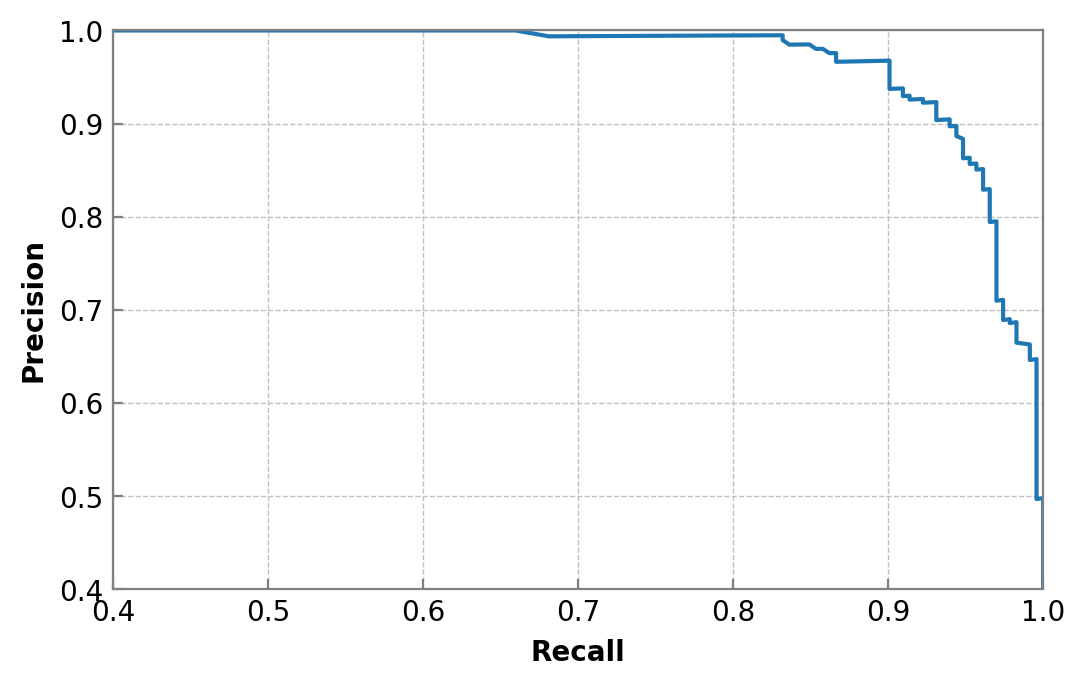

In [52]:
from matplotlib import pyplot as plt

ps, rs, ths = ([], [], [])
th = np.max(pred_es)
while th >= 0.0:
    p, r = pr_at_th(th)
    if p > 0:
        ps.append(p)
        rs.append(r)
    else:
        ps.append(1.0)
        rs.append(0.0)
    ths.append(th)
    th -= 0.0005
    
from sklearn import metrics

print(f'AUC: {metrics.auc(rs, ps)}, max R: {max(rs)}, max P: {max(ps)}')
    
i = len(rs) - 1
while rs[i] == 1.0:
    i -= 1
i += 1
print(f'100% recall at: {int(ps[i] * 100)}%, threshold: {ths[i]}')

fig, ax = plt.subplots(figsize=(6, 3.7), dpi=200)

ax.spines['top'].set_color('#808080')
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.spines['bottom'].set_color('#808080')
ax.tick_params(direction='in', color='#808080')

plt.grid(color='#c0c0c0', linestyle='--', linewidth=0.5)

plt.ylabel('Precision', fontweight='bold')
plt.xlabel('Recall', fontweight='bold')

plt.xlim((0.4, 1.0))
plt.ylim((0.4, 1.0))

_ = plt.plot(rs, ps)